In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# We can also create a target_transform if needed
""" target_transform = transforms.Compose([
    transforms.Lambda(lambda y: torch.zeros(10, dtype = torch.float).scatter_(0, torch.tensor(y), value = 1))
])
"""

' target_transform = transforms.Compose([\n    transforms.Lambda(lambda y: torch.zeros(10, dtype = torch.float).scatter_(0, torch.tensor(y), value = 1))\n])\n'

In [3]:
full_train_set = torchvision.datasets.CIFAR100(root = "./data2", train = True, download = False, transform = transform)

test_set = torchvision.datasets.CIFAR100(root = "./data2", train = False, download = False, transform = transform)

In [4]:
# Defining the size of the validation set
val_size = 10000
train_size = len(full_train_set) - val_size

In [5]:
train_subset, val_subset = torch.utils.data.random_split(full_train_set, [train_size, val_size])

print(f"Full training set size: {len(full_train_set)}")
print(f"New training set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")
print(f"Test set size: {len(test_set)}")

Full training set size: 50000
New training set size: 40000
Validation set size: 10000
Test set size: 10000


In [6]:
batch_size = 64

train_loader = DataLoader(dataset = train_subset, batch_size = batch_size, shuffle = True)                              
val_loader = DataLoader(dataset = val_subset, batch_size = batch_size, shuffle  = False)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = False)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")


Using device: cuda:0


In [8]:
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.block5 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features = 7*7*512, out_features = 4096),
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(in_features = 4096, out_features = 4096),
            nn.ReLU()
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(in_features = 4096, out_features = 100)
        )
        
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out
        

In [10]:
model_vgg19 = VGG19().to(device)

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_vgg19.parameters(), lr = 0.0001)
n_epochs = 10

In [12]:
def evaluate_model(model, data_loader, loss_function, device):
    # Evaluates the model on the given dataset
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = loss_function(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

In [13]:
def training_loop(model, train_loader, val_loader, test_loader, loss_function, optimizer, n_epochs, device):
    
    history = {
        "train_losses" : [], "train_accs": [],
        "val_losses": [], "val_accs": [],
        "test_losses": [], "test_accs": []
    }
    
    for epoch in range(n_epochs):
        # Training Phase
        model.train()
        running_train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        avg_train_acc = 100 * train_correct / train_total
        
        
        # Evaluation Phase
        val_loss, val_acc = evaluate_model(model, val_loader, loss_function, device)
        test_loss, test_acc = evaluate_model(model, test_loader, loss_function, device)
        
        history['train_losses'].append(avg_train_loss)
        history['train_accs'].append(avg_train_acc)
        history['val_losses'].append(val_loss)
        history['val_accs'].append(val_acc)
        history['test_losses'].append(test_loss)
        history['test_accs'].append(test_acc)
        
        print(f"Epoch [{epoch + 1}/{n_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        
    print("Finished Training!")
    return history

In [14]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    """Plots the training, validation, and test metrics."""
    epochs = range(1, len(history['train_losses']) + 1)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Loss
    ax1.plot(epochs, history['train_losses'], 'o-', label='Training Loss')
    ax1.plot(epochs, history['val_losses'], 'o-', label='Validation Loss')
    ax1.plot(epochs, history['test_losses'], 'o-', label='Test Loss')
    ax1.set_title('Loss vs. Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_xticks(epochs)


    # Plot Accuracy
    ax2.plot(epochs, history['train_accs'], 'o-', label='Training Accuracy')
    ax2.plot(epochs, history['val_accs'], 'o-', label='Validation Accuracy')
    ax2.plot(epochs, history['test_accs'], 'o-', label='Test Accuracy')
    ax2.set_title('Accuracy vs. Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.set_xticks(epochs)

    plt.tight_layout()
    plt.show()

In [15]:
training_history = training_loop(model = model_vgg19,
                                 train_loader = train_loader,
                                 val_loader = val_loader, 
                                 test_loader = test_loader, 
                                 loss_function = loss_fn,
                                 optimizer = optimizer,
                                 n_epochs = n_epochs,
                                 device = device)

KeyboardInterrupt: 

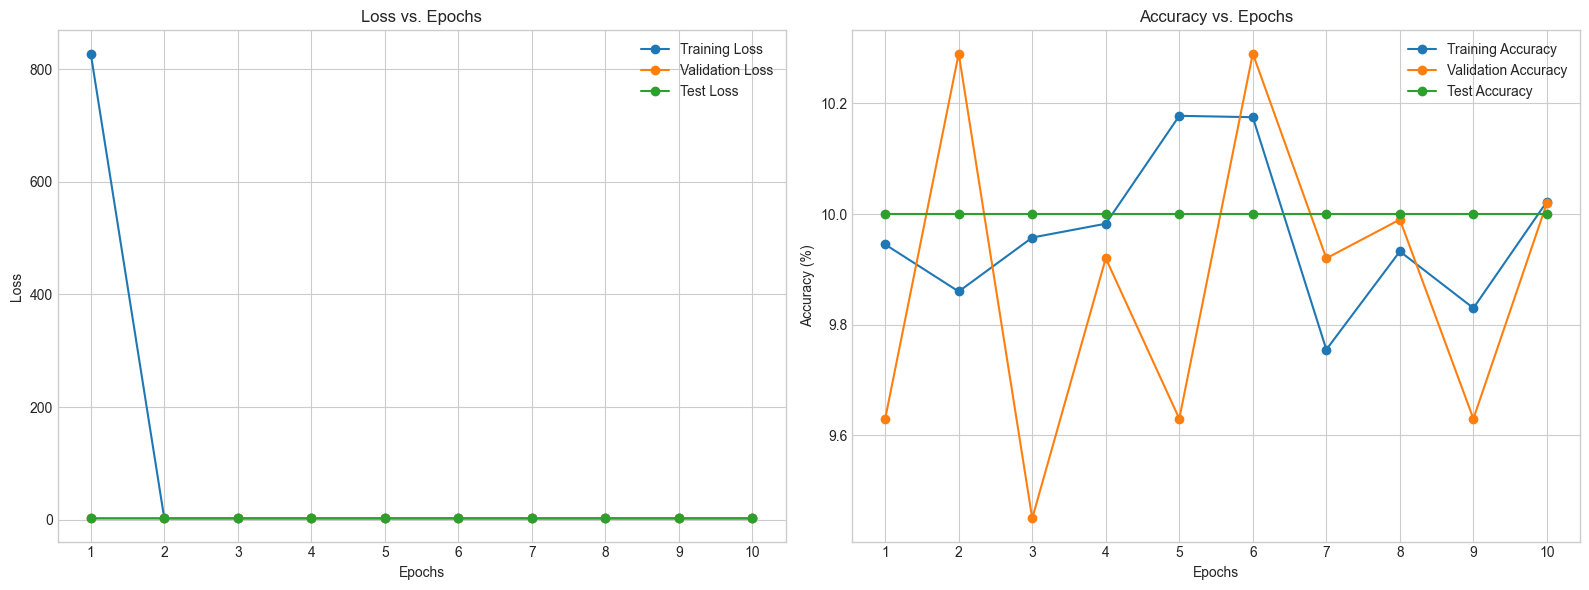

In [ ]:
plot_metrics(training_history)

In [ ]:
final_test_loss, final_test_acc = evaluate_model(model_vgg19, test_loader, loss_fn, device)

print(f'\nFinal accuracy on the 10000 test images: {final_test_acc:.2f}%')


Final accuracy on the 10000 test images: 10.00%
